In [1]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA, GOOG, EURUSD
import pandas as pd
import talib as ta
import yfinance as yf
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

/Users/harsnyi/Documents/backtesting/venv/lib/python3.12/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
MAJORS = [
    "AUDUSD",
    "EURCHF",
    "EURGBP",
    "EURJPY",
    "EURUSD",
    "GBPJPY",
    "GBPUSD",
    "NZDUSD",
    "USDCAD",
    "USDCHF",
    "USDJPY"
]

In [3]:
BACKTEST_YEARS = 3

In [4]:
class SmaCrossWithADX(Strategy):
    n1 = 4  
    n2 = 9
    n3 = 50
    n4 = 200
    adx_period = 14
    adx_threshold = 25
    risk_per_trade = 0.01
    max_position_days = 10

    def init(self):
        close = self.data.Close
        high = self.data.High
        low = self.data.Low

        self.sma4 = self.I(SMA, close, self.n1)
        self.sma9 = self.I(SMA, close, self.n2)
        self.sma50 = self.I(SMA, close, self.n3)
        
        self.adx = self.I(ta.ADX, high, low, close, timeperiod=self.adx_period)

    def next(self):
        current_price = self.data.Close[-1]
        account_balance = self.equity
    
        for trade in self.trades:
            if trade.is_long:
                days_open = (self.data.index[-1] - trade.entry_time).days
                if days_open >= self.max_position_days:
                    self.position.close()
        if self.position:
            pass
        # self.adx[-1] >= self.adx_threshold
        elif crossover(self.sma4, self.sma9) and self.adx[-1] and self.sma50 <= current_price:
            stop_loss = current_price * 0.99
            take_profit = current_price * 1.02
            self.buy(sl=stop_loss, tp=take_profit)

In [5]:
def get_historic_data(ticker) -> pd.DataFrame:
    ticker_c = f"{ticker}=X"
    historical_data = yf.download(ticker_c, period=f"{BACKTEST_YEARS}y", interval="1d")
    historical_data.columns = [col[0] for col in historical_data.columns]
    curr_value = historical_data.iloc[-1]["Close"]
    
    #Shift the data by 1 to get the next day's close (yFinance bug)
    historical_data["Close"] = historical_data["Open"].shift(-1)
    historical_data.loc[historical_data.index[-1], "Close"] = curr_value
    historical_data["Volume"] = 100
    return historical_data

In [6]:
min_w_rate = 25
trades = np.zeros(len(MAJORS))
win_rates = np.zeros(len(MAJORS))
returns = np.zeros(len(MAJORS))
for i, m in enumerate(MAJORS):
    historical_data = get_historic_data(m)
    bt = Backtest(historical_data, SmaCrossWithADX,
                  cash=10000, commission=0,
                  exclusive_orders=True)
    output = bt.run()
    trades[i] = output["# Trades"]
    win_rates[i] = output["Win Rate [%]"]
    returns[i] = output["Return [%]"]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


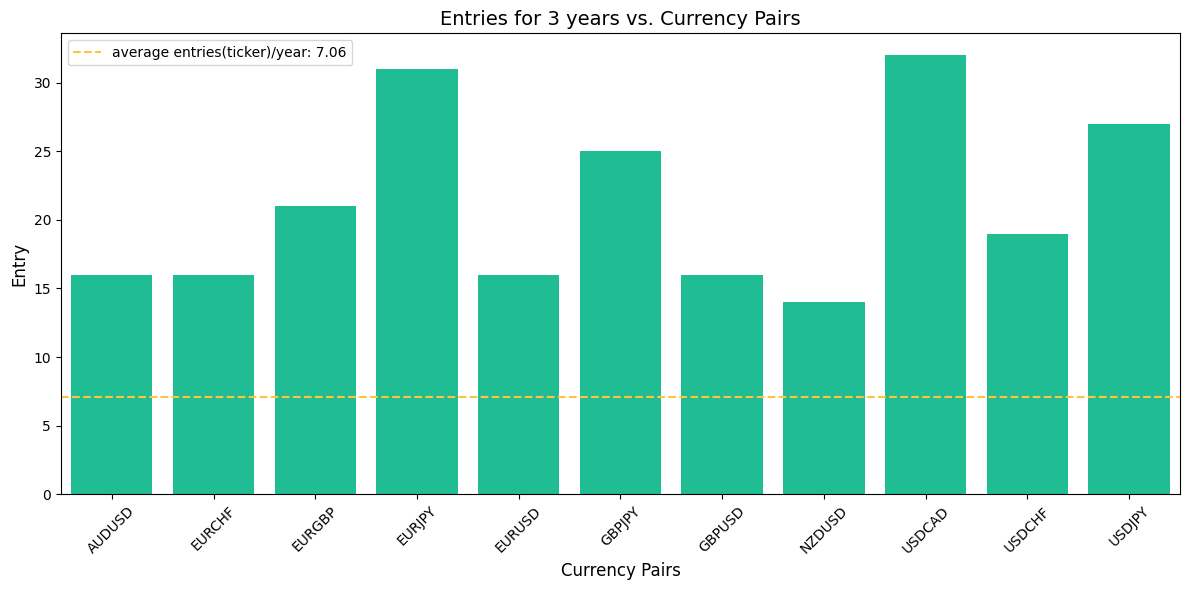

In [7]:
avg_entries_year = sum((trades / 3)) / len(trades)
avg_entries_year

plt.figure(figsize=(12, 6))
sns.barplot(x=MAJORS, y=trades, color="#06D6A0")

plt.xlabel("Currency Pairs", fontsize=12)
plt.ylabel("Entry", fontsize=12)
plt.title(f"Entries for {BACKTEST_YEARS} years vs. Currency Pairs", fontsize=14)
plt.axhline(y=avg_entries_year, color="#FFC43D", linestyle="--", label=f"average entries(ticker)/year: {round(avg_entries_year, 2)}")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()

# Display the plot
plt.show()


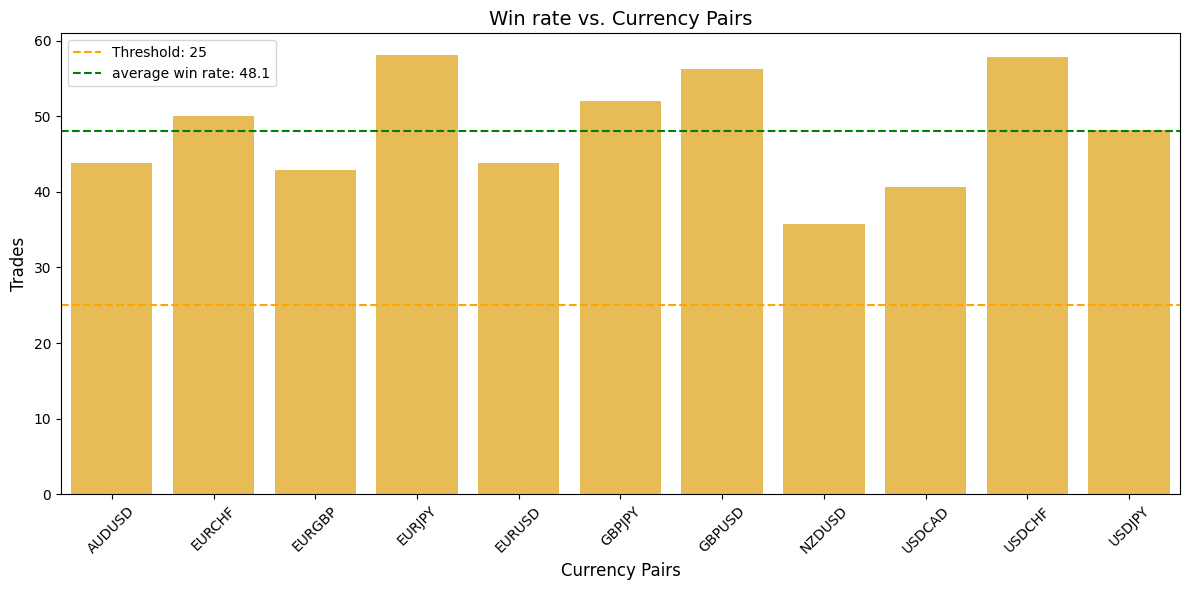

In [8]:
avg_win_rate = sum(win_rates) / len(win_rates)
avg_win_rate_c = "green" if avg_win_rate > min_w_rate else "red"
plt.figure(figsize=(12, 6))
sns.barplot(x=MAJORS, y=win_rates, color="#FFC43D")

plt.xlabel("Currency Pairs", fontsize=12)
plt.ylabel("Trades", fontsize=12)
plt.title("Win rate vs. Currency Pairs", fontsize=14)
plt.axhline(y=min_w_rate, color="orange", linestyle="--", label=f"Threshold: {min_w_rate}")
plt.axhline(y=avg_win_rate, color=avg_win_rate_c, linestyle="--", label=f"average win rate: {round(avg_win_rate, 2)}")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()

# Display the plot
plt.show()

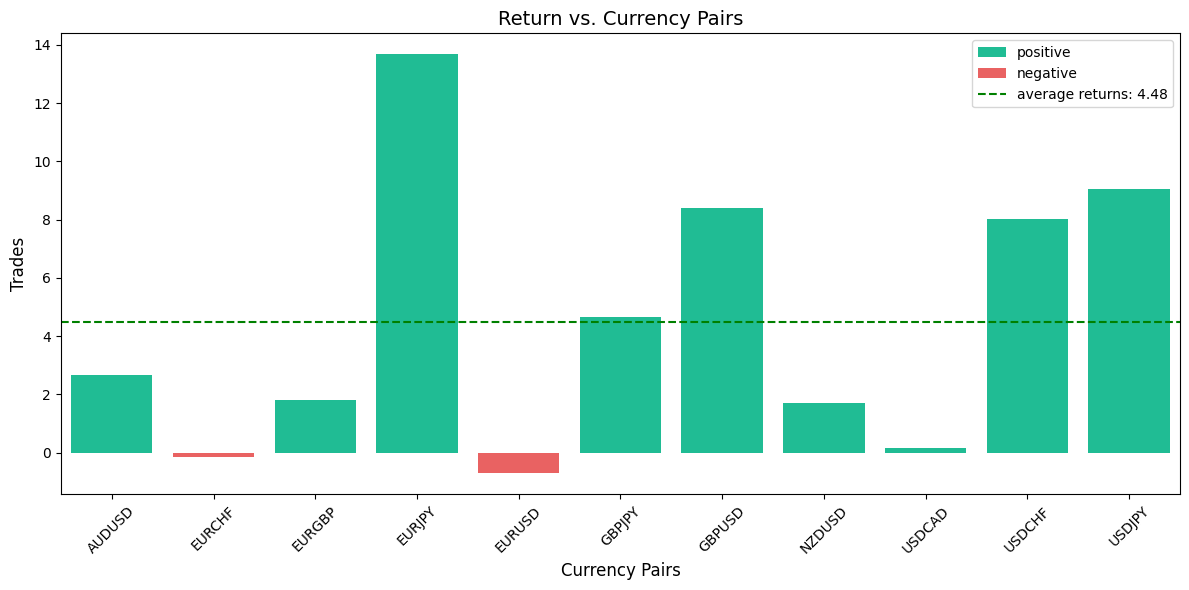

In [9]:
avg_returns = sum(returns) / len(returns)
avg_return_c = "green" if avg_returns > 0 else "red"

bar_colors = ["positive" if r > 0 else "negative" for r in returns]
palette = {"positive": "#06D6A0", "negative": "#FF4C4C"}
plt.figure(figsize=(12, 6))
sns.barplot(x=MAJORS, y=returns, color="#06D6A0", hue=bar_colors, dodge=False, palette=palette)

plt.xlabel("Currency Pairs", fontsize=12)
plt.ylabel("Trades", fontsize=12)
plt.title("Return vs. Currency Pairs", fontsize=14)
plt.axhline(y=avg_returns, color=avg_return_c, linestyle="--", label=f"average returns: {round(avg_returns, 2)}")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()

# Display the plot
plt.show()

In [12]:
historical_data = get_historic_data("EURCHF")
bt = Backtest(historical_data, SmaCrossWithADX,
                  cash=10000, commission=0,
                  exclusive_orders=True)
output = bt.run()
print(output)

[*********************100%***********************]  1 of 1 completed

Start                     2022-01-24 00:00:00
End                       2025-01-22 00:00:00
Duration                   1094 days 00:00:00
Exposure Time [%]                    14.96164
Equity Final [$]                   9984.20895
Equity Peak [$]                   10220.82385
Return [%]                           -0.15791
Buy & Hold Return [%]                -8.72758
Return (Ann.) [%]                    -0.05091
Volatility (Ann.) [%]                 2.21147
CAGR [%]                              -0.0364
Sharpe Ratio                         -0.02302
Sortino Ratio                         -0.0317
Calmar Ratio                         -0.01432
Max. Drawdown [%]                    -3.55619
Avg. Drawdown [%]                    -2.15889
Max. Drawdown Duration      959 days 00:00:00
Avg. Drawdown Duration      495 days 00:00:00
# Trades                                   16
Win Rate [%]                             50.0
Best Trade [%]                            2.0
Worst Trade [%]                   

In [11]:
bt.plot()

GridPlot(id='p1396', ...)